[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/breakpoints.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239469-lesson-2-breakpoints)

# Breakpoints

## Review

For `human-in-the-loop`, we often want to see our graph outputs as its running. 

We laid the foundations for this with streaming. 

## Goals

Now, let's talk about the motivations for `human-in-the-loop`:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state 

LangGraph offers several ways to get or update agent state to support various `human-in-the-loop` workflows.

First, we'll introduce [breakpoints](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/breakpoints/#simple-usage), which provide a simple way to stop the graph at specific steps. 

We'll show how this enables user `approval`.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt

## Breakpoints for human approval

Let's re-consider the simple agent that we worked with in Module 1. 

Let's assume that are concerned about tool use: we want to approve the agent to use any of its tools.
 
All we need to do is simply compile the graph with `interrupt_before=["tools"]` where `tools` is our tools node.

This means that the execution will be interrupted before the node `tools`, which executes the tool call.

In [3]:
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

@tool
def and_op(a: bool, b: bool) -> bool:
    """Perform a logical AND operation.

    Args:
        a: first boolean
        b: second boolean
    """
    return a and b

@tool
def or_op(a: bool, b: bool) -> bool:
    """Perform a logical OR operation.

    Args:
        a: first boolean
        b: second boolean
    """
    return a or b

@tool
def xor_op(a: bool, b: bool) -> bool:
    """Perform a logical XOR operation.

    Args:
        a: first boolean
        b: second boolean
    """
    return a ^ b

# --- New Tool Lists ---
arithmetic_tools = [add, multiply, divide]
logical_tools = [and_op, or_op, xor_op]
all_tools = arithmetic_tools + logical_tools # For the LLM

llm = ChatOpenAI(model="gpt-4o")
# Bind ALL tools to the LLM so it knows about them
llm_with_tools = llm.bind_tools(all_tools)

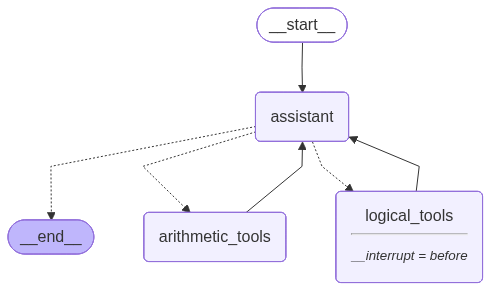

In [4]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, END
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic or logical operations on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# --- New Custom Routing Function ---
# Get the names of the tools for routing
arithmetic_tool_names = {t.name for t in arithmetic_tools}
logical_tool_names = {t.name for t in logical_tools}

def route_to_tool_node(state: MessagesState):
    """Routes to the correct tool node or ends the graph."""
    last_message = state['messages'][-1]
    if not last_message.tool_calls:
        return END

    # Route based on the first tool call
    first_tool_name = last_message.tool_calls[0].get('name')
    if first_tool_name in arithmetic_tool_names:
        return "arithmetic_tools"
    if first_tool_name in logical_tool_names:
        return "logical_tools"
    
    # Fallback
    return END

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
# --- Add TWO separate tool nodes ---
builder.add_node("arithmetic_tools", ToolNode(arithmetic_tools))
builder.add_node("logical_tools", ToolNode(logical_tools))


# Define edges: these determine the control flow
builder.add_edge(START, "assistant")

# --- Use the new custom router ---
builder.add_conditional_edges(
    "assistant",
    route_to_tool_node,
    {
        "arithmetic_tools": "arithmetic_tools", # Route to arithemtic
        "logical_tools": "logical_tools",       # Route to logical
        END: END
    }
)
# Add edges from both tool nodes back to the assistant
builder.add_edge("arithmetic_tools", "assistant")
builder.add_edge("logical_tools", "assistant")


memory = MemorySaver()
# --- THE KEY CHANGE: Only interrupt before 'logical_tools' ---
graph = builder.compile(interrupt_before=["logical_tools"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [5]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_0xhQ8nFQ52jlS6PZAbmItbTz)
 Call ID: call_0xhQ8nFQ52jlS6PZAbmItbTz
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


In [ ]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

In [7]:
# Input
initial_input = {"messages": HumanMessage(content="2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

2 and 3
================================== Ai Message ==================================
Tool Calls:
  and_op (call_2lyED0DVw5K18AvFd9N4pdZZ)
 Call ID: call_2lyED0DVw5K18AvFd9N4pdZZ
  Args:
    a: True
    b: True


We can get the state and look at the next node to call.

This is a nice way to see that the graph has been interrupted.

In [8]:
state = graph.get_state(thread)
state.next

('logical_tools',)

Now, we'll introduce a nice trick.

When we invoke the graph with `None`, it will just continue from the last state checkpoint!

![breakpoints.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbae7985b747dfed67775d_breakpoints1.png)

For clarity, LangGraph will re-emit the current state, which contains the `AIMessage` with tool call.

And then it will proceed to execute the following steps in the graph, which start with the tool node.

We see that the tool node is run with this tool call, and it's passed back to the chat model for our final answer.

In [9]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  and_op (call_2lyED0DVw5K18AvFd9N4pdZZ)
 Call ID: call_2lyED0DVw5K18AvFd9N4pdZZ
  Args:
    a: True
    b: True
================================= Tool Message =================================
Name: and_op

true
================================== Ai Message ==================================

The logical AND operation between "true" and "true" (representing "2 and 3" in non-numeric terms) is "true". If you meant numerical addition, please specify.


Now, lets bring these together with a specific user approval step that accepts user input.

### Breakpoints with LangGraph API

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

The LangGraph API [supports breakpoints](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_breakpoint/#sdk-initialization). 

In [10]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [13]:
# This is the URL of the local development server
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

As shown above, we can add `interrupt_before=["node"]` when compiling the graph that is running in Studio.

However, with the API, you can also pass `interrupt_before` to the stream method directly. 

In [14]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent", 
    input=initial_input,
    stream_mode="values",
    interrupt_before=["tools"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '276723b9-5574-4b75-aa4e-d15e9c5f2641'}
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 170, 'total_tokens': 187, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb3c3cb84d', 'id': 'chatcmpl-CUDM9BactOILXbDihco6LSqo0ZXB9', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': Non

Now, we can proceed from the breakpoint just like we did before by passing the `thread_id` and `None` as the input!

In [15]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=None,
    stream_mode="values",
    interrupt_before=["tools"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 170, 'total_tokens': 187, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb3c3cb84d', 'id': 'chatcmpl-CUDM9BactOILXbDihco6LSqo0ZXB9', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'lc_run--08c15142-bbab-4275-a01d-e5cb6f3285f5-0', 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_5YaNdCnQ7VMZim9OuTZ1ZmZj', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 170, 

In [18]:
initial_input = {"messages": HumanMessage(content="what is 2 xor 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent", 
    input=initial_input,
    stream_mode="values",
    interrupt_before=["tools"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)
    async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=None,
    stream_mode="values",
    interrupt_before=["tools"],
):
     print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: metadata...
Receiving new event of type: values...
{'content': 'The XOR (exclusive or) operation is a bitwise operation. To find 2 XOR 3, we need to look at the binary representations of these numbers:\n\n- 2 in binary is `10`\n- 3 in binary is `11`\n\nPerform XOR on each of the corresponding bits:\n\n```\n   10\n   11\n   --\n   01\n```\n\nThis results in `01` in binary, which is `1` in decimal. So, 2 XOR 3 equals 1.', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 107, 'prompt_tokens': 171, 'total_tokens': 278, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb3c3cb84d', 